## Predict with pre-trained models
This is a very slightly modified version of the ``Predict with pre-trained models'' example from http://mxnet.io/tutorials/python/predict_imagenet.html.  The only change has been the addition of a function to pull an image from a local directory and also configured so that a gpu is not needed.  

From the MXNet page:
"This is a demo for predicting with a pre-trained model on the full imagenet dataset, which contains over 10 million images and 10 thousands classes. For a more detailed explanation, please refer to predict.ipynb."

This was run using the AWS Machine Learning AMI

First we downloat the model.

if you are using python3 you will need to install urllib.request

and you will need to install mxnet

In [7]:
#!pip install mxnet

In [8]:
import os, urllib
import urllib
#for python 3 use urllib.request
import mxnet as mx
def download(url,prefix=''):
    filename = prefix+url.split("/")[-1]
    if not os.path.exists(filename):
        #for python3 use urllib.requests.urlretrieve(url,filename)
        urllib.urlretrieve(url, filename)

path='http://data.mxnet.io/models/imagenet-11k/'
download(path+'resnet-152/resnet-152-symbol.json', 'full-')
download(path+'resnet-152/resnet-152-0000.params', 'full-')
download(path+'synset.txt', 'full-')


In [9]:
with open('full-synset.txt', 'r') as f:
    synsets = [l.rstrip() for l in f]

sym, arg_params, aux_params = mx.model.load_checkpoint('full-resnet-152', 0)

In [15]:
mod = mx.mod.Module(symbol=sym)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
mod.set_params(arg_params, aux_params)

In [13]:
%matplotlib inline
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

In [20]:
def get_image(url, show=True):
    filename = url.split("/")[-1]
    print(filename)
    urllib.urlretrieve(url,filename)
    # for python 3 urllib.request.urlretrieve(url, filename)
    img = cv2.imread(filename)
    if img is None:
        print('failed to download ' + url)
        return ''
    if show:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    return filename


In [17]:
def get_local(filename, show=True):
    img = cv2.imread(filename)
    if img is None:
        print('failed to load ' + filename)
        return ''
    if show:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    return filename
    

This function does the prediction by converting the image to an RGB format of the right size.

In [18]:
def predict(filename, mod, synsets):
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    if img is None:
        return None
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    a = np.argsort(prob)[::-1]    
    for i in a[0:5]:
        print('p=%2.2f,%s' %(prob[i], synsets[i][synsets[i].find(' '):]))
    

now run the predictor.  use a local jpg file or modify to use get_image with a url or a jpg file

add a url and run

maxresdefault.jpg
p=0.19, garbage truck, dustcart
p=0.10, blacktop, blacktopping
p=0.09, garbage man, garbageman, garbage collector, garbage carter, garbage hauler, refuse collector, dustman
p=0.05, harvester, reaper
p=0.04, broadcaster, spreader


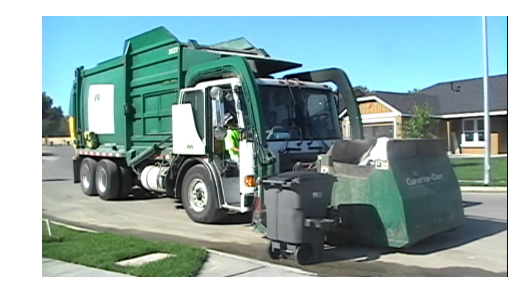

In [22]:
url = 'http://www.vetbook.org/wiki/dog/images/thumb/5/5c/Lowchen.jpg/694px-Lowchen.jpg'
url = 'https://cdn.pixabay.com/photo/2016/10/15/12/01/dog-1742295_960_720.jpg'
url = 'https://www.danmurphys.com.au/media/DM/Product/750x2000/379034_0_9999_v1_m56577569837963866.jpg'
url = 'https://img-new.cgtrader.com/items/20608/heineken_beer_bottle_3d_model_fbx_lwo_lw_lws_obj_max_lxo_79aea18d-613b-46ab-b323-2bc0c3a740dc.jpg'
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Official_Portrait_of_President_Reagan_1981.jpg/1200px-Official_Portrait_of_President_Reagan_1981.jpg'
url = 'http://3.bp.blogspot.com/-wRi2GBtO-Yk/T3cYy2VIgRI/AAAAAAAAB-8/Z9X6Jjc1P34/s1600/great-blue-heron.jpg'
url = 'http://assets.nydailynews.com/polopoly_fs/1.2773122.1472670685!/img/httpImage/image.jpg_gen/derivatives/article_750/nydn-2016-chevrolet-corvette-stingray-arctic-white-front-quarter-3.jpg'
url = 'http://i1.ytimg.com/vi/UxUBDJlsnjI/maxresdefault.jpg'
file = get_image(url)
predict(file, mod, synsets)
